# Generative Adversarial Network for FashionMNIST

In [1]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms

/apps/daint/UES/6.0.UP04/sandboxes/sarafael/ml2024/lib/python3.9/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


Let's import the usual Python suspects:

In [2]:
import numpy as np

In [3]:
import tqdm

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In order to avoid surprises due to the random initialization of weights in our models, we set the random seed. See [PyTorch: Reproducibility](https://pytorch.org/docs/stable/notes/randomness.html) for more details.

In [5]:
import random

seed = 42

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Description

In this notebook, we are going to build a Generative Adversarial Network (GAN) to generate new images that look like the ones contained in the [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) dataset.

*Once you finish going throught this notebook, you can try to run the same notebook with the MNIST data set.* 

### GPU

Before we start, let's define the `torch.device` we will use for training:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Dataset

Let's download the FashionMNIST data set. Since we are working with a generative model and trying to learn the underlying data distribution of the training set, we don't need to worry about the validation or test sets.

*Define a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) from the `trainset` data set. Use the pre-defined `batch_size` (hyperparameter), and enable shuffling of the examples. Drop the last batch (with a different batch size), to make things easier (we hard-code `batch_size` in several places, and use it for assertions).*

In [7]:
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to PyTorch tensor
    transforms.Normalize(0.5, 0.5) # Normalise images: out = (in - mean) / std
])

trainset = datasets.FashionMNIST(root="data/", train=True, download=True, transform=transform)

# Define the trainloader using a PyTorch DataLoader
# TODO
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)

trainiter = iter(trainloader)

It is always a good idea to have a look at the data. Let's plot a bunch of samples.

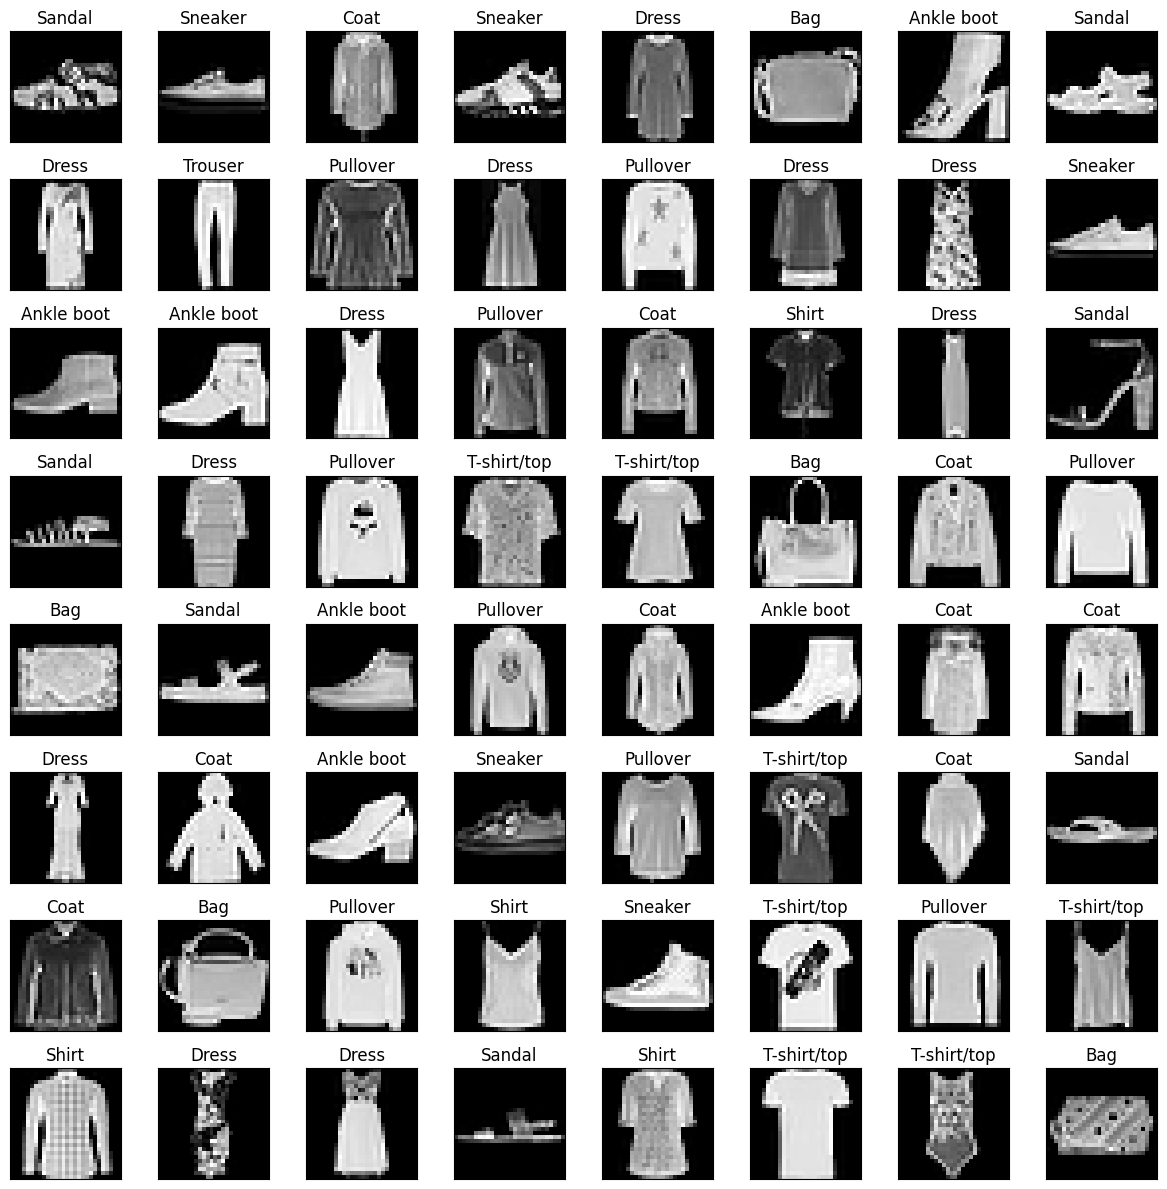

In [8]:
label_to_name = { 
    i : name 
    for i, name in enumerate(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
}

images, labels = next(trainiter)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])

    img = images[idx].numpy()
    
    img = img * 0.5 + 0.5 

    img = np.transpose(img, (1, 2, 0))
    
    plt.imshow(img, cmap='gray')
    
    name = str(label_to_name[labels[idx].item()])
    
    ax.set_title(name, fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()

## Model

On simple toy examples such as MNIST, we can get reasonable results already with fully connected generator and discriminator networks (with dropout layers and leaky ReLU activation functions). _Try it!_ However, in order to get good results, we are implementing here a deep convolutional GAN (DCGAN) model, using `nn.Conv2D` and `nn.Conv2DTranspose` layers.

### Discriminator

The discriminator network $D(x)$ takes an image $x$ as input and outputs the probability of $x$ being a real image (coming from the training data), rather thank a fake (generated) image. It is therefore a binary classifier based on 2D convolutions, like we have seen before. However, since we are working with binary classification, we will produce a single output (the probability $p$ of the image being real), instead of the two class probabilities. The probability of the image being fake is simply $1-p$.

However, the architecture is a bit different from the one we have seen before (with `nn.MaxPool` for downsampling and `nn.Linear` for classification). GANs are notoriously difficult to train, as we discussed. Therefore, we follow the architrcture guidelines from the [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) paper:
* Replace pooling layers with strided convolutions
* Use batch normalisation
* Remove fully connected hidden layers
* Use `nn.LeakyReLU` activation for the discriminator 

In order to remove pooling layer, we can choose the stride so that the spatial dimension is divided by 2 at each convolution. In order to remove the final fully connected layer(s), we need to set the `kernel_size`, `stride`, and `padding` of the last convolutional layer in such a way that the there is a single number as output (the probability of a real image). 

*Given the layers provided below, implement the forward pass.*

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lrelu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 1, kernel_size=2, stride=2, padding=0)

    def forward(self, x):

        # First convolution and activation
        # TODO
        x = self.conv1(x)
        x = self.lrelu(x)
        
        assert x.shape == (batch_size, 64, 14, 14), x.shape
        
        # Second convolution, batch normalisation, and activation
        # TODO
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.lrelu(x)
        assert x.shape == (batch_size, 128, 7, 7), x.shape
        
        # Third convolution, batch normalisation, and activation
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.lrelu(x)
        assert x.shape == (batch_size, 256, 3, 3), x.shape

        # Last convolution
        # TODO
        x = self.conv4(x)
        assert x.shape == (batch_size, 1, 1, 1), x.shape
        
        # Reshape to have a single output (per batch)
        # TODO
        
        return x.view(-1, 1)

Let's test that we can propagate a batch of images through the discriminator and get an output with the correct shape:

In [10]:
D = Discriminator()
D(torch.ones((batch_size, 1, 28, 28))).shape

torch.Size([128, 1])

### Generator

The generator network $G(z)$ takes a latent space sample $z$ (random noise) and ouputs an image. The goal of the generator is to approximate the data distribution $p_\text{data}$, so that output images are similar to the ones in the training set.

We follow the architrcture guidelines from the [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/pdf/1511.06434.pdf) paper:
* Use transpose convolutions
* Use batch normalisation
* Remove fully connected hidden layers
* Use `nn.ReLU` activation for the generator (`nn.Tanh` for the last layer)

*Given the layers defined below, implement the forward pass.*

In [11]:
class Generator(nn.Module):

    def __init__(self, z_size):
        super().__init__()
        
        self.z_size = z_size
    
        self.relu = nn.ReLU()
    
        self.conv1 = nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(512)
        
        self.conv2 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(256)
        
        self.conv3 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.ConvTranspose2d(128, 1, 2, stride=2, padding=2, bias=False)

    def forward(self, x):
        # Re-shape input
        # The latent space vector is interpreted as feature maps of size 1x1
        # TODO
        x = x.view(batch_size, self.z_size, 1, 1)
        
        # First convolution, batch normalisation, and activation
        # TODO
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        assert x.shape == (batch_size, 512, 4, 4), x.shape
        
        # Second convolution, batch normalisation, and activation
        # TODO
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        assert x.shape == (batch_size, 256, 8, 8), x.shape
        
        # Third convolution, batch normalisation, and activation
        # TODO
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        assert x.shape == (batch_size, 128, 16, 16), x.shape
        
        # Last convolution
        # TODO
        x = self.conv4(x)
        
        assert x.shape == (batch_size, 1, 28, 28), x.shape
        
        # tanh activation function
        # TODO
        x = F.tanh(x)

        return x

Let's check that we can generate an image of the correct size from a latent space vector:

In [12]:
G = Generator(100)
G(torch.ones((batch_size, 100))).shape

torch.Size([128, 1, 28, 28])

## Training

Once we have defined the architecture of the generator and discriminator networks, we can create an instance of both. We also define the size of the latent space representation $z$. This is yet another hyperparameter of the model.

In [13]:
# Generator latent vector size
z_size = 100

D = Discriminator().to(device)
G = Generator(z_size).to(device)

### Losses

We define two losses, for convenience. The losses take the output of the discriminator (probability of images being real). In the `real_loss` the labels are all set to real images, while in the `fake_loss` the labels are all set to fake images.

*Since the discriminator has a simple output, we need to use the `binary_cross_entropy_with_logits` loss, in order to compute the (binary) cross-entropy loss with the raw output of the model.*

In [14]:
def real_loss(D_out, device=device):
    # The labels should represent real images (for the discriminator)
    # Hint: use torch.ones or torch.zeros and the correct batch size
    # TODO
    labels = torch.ones(batch_size).to(device)
            
    # Compute the binary cross entropy loss
    # TODO
    loss =  F.binary_cross_entropy_with_logits(D_out.squeeze(), labels)
    
    return loss

In [15]:
def fake_loss(D_out, device=device):
    # The labels should represent fake images (for the discriminator)
    # Hint: use torch.ones or torch.zeros and the correct batch size
    # TODO
    labels = torch.zeros(batch_size).to(device)
    
    # Compute the binary cross entropy loss
    # TODO
    loss = F.binary_cross_entropy_with_logits(D_out.squeeze(), labels)

    return loss

### Optimiser

For the oprimizer, we use again the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer. Since we are trying to train two models at the same time,  we need two optimisers (one for each model). For simplicity, we use the same learning rate and momentum. $\beta_1=1/2$ is set according to the DCGAN paper.

In [16]:
# Optimizers
lr = 1e-3

# Create optimizers for discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, betas=(0.5, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(0.5, 0.999))

### Weight Initialisation

In the DCGAN paper, all model weights are randomly initialized from a normal distribution with mean `0`, and standard deviation `0.02`.

In [17]:
def weights_init(m):
    layer = m.__class__.__name__
    if layer.startswith('Conv'): # Both Conv and ConvTranspose
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif layer.startswith('BatchNorm'):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

*Apply the custom weight initialisation to both the discriminator and the generator.*

In [18]:
# TODO
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (relu): ReLU()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 1, kernel_size=(2, 2), stride=(2, 2), padding=(2, 2), bias=False)
)

### Training Loop

During training we will save some generated samples, in order to visualize how the training progressed ath the end. Therefore, we define a batch of fixed latent space vectors $z$ that we re-use each time:

In [19]:
sample_size = batch_size # Remvoe assertions in generator to make this work with different sizes

fixed_z = torch.randn(sample_size, z_size).to(device)

Finally, we can write the training loop. As we have seen, the training proceeds in two phases for each mini-batch. 

_Implement these phases in the training loop._

**_Discriminator training_**:
 * _Apply the discriminator to real images and compute the (real) loss_
 * _Generate  a batch of fake images (sample $z$, then compute $G(z)$_
 * _Apply the dirscriminator to real images and compute the (fake) loss_
 * _Compute the total loss by summing the two losses above_


**_Generator training_**:
 * _Generate  a batch of fake images (sample $z$, then compute $G(z)$_
 * _Apply the dirscriminator to fake images and compute the (real) loss_

The clever bit of GANs is in the last bullet point: when training the generator, we pretend that the generated images are real when we pass them to the discriminator. Since we are only updating the weights of the generator, the only way to improve this loss if for the generator to generate better images.

In [20]:
from tqdm import trange, tqdm

n_epochs = 15

# Keep track of loss and generated, "fake" samples
samples = []
losses = []

# Models in train model (for dropout layers)
D.train()
G.train()

iters = 0
pbar = trange(n_epochs, desc='Training', leave=True)
for epoch in pbar:
    
    for real_images, _ in trainloader:
        
        real_images = real_images.to(device)
                
        # @@@@@@@@@@@@@@@@@@@@@@
        # DISCRIMINATOR TRAINING
        # @@@@@@@@@@@@@@@@@@@@@@
        
        d_optimizer.zero_grad()

        # Discriminator predictions and loss for real images
        # TODO
        D_real = D(real_images) 
        d_real_loss = real_loss(D_real)
        
        # Generate fake images
        # TODO
        z = torch.randn(batch_size, z_size).to(device)
        fake_images = G(z)
        
        # Discriminator predictions and loss for fake images
        # TODO
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        
        # Backpropagation
        # TODO
        d_loss.backward()

        # Update weights of the discriminator
        # TODO
        d_optimizer.step()
        
        # @@@@@@@@@@@@@@@@@@
        # GENERATOR TRAINING
        # @@@@@@@@@@@@@@@@@@
        
        g_optimizer.zero_grad()
        
        # Generate fake images
        # TODO
        z = torch.randn(batch_size, z_size).to(device)
        fake_images = G(z)
        
        # Discriminator predictions and loss for fake images
        # This now uses real_loss instead of fake_loss
        # in order to flip the labels
        # TODO
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake)
        
        # Backpropagation
        # TODO
        g_loss.backward()
        
        # Update weights of the generator
        # TODO
        g_optimizer.step()
        
        # @@@@@@@@@@@@@@@@@@
        
        # Store losses
        losses.append((d_loss.item(), g_loss.item()))
        
        if iters % 250 == 0:
            # Generate fake images from fixed sample
            G.eval()
            with torch.no_grad():
                samples.append(G(fixed_z))
            G.train()

Training: 100%|██████████| 15/15 [07:54<00:00, 31.62s/it]


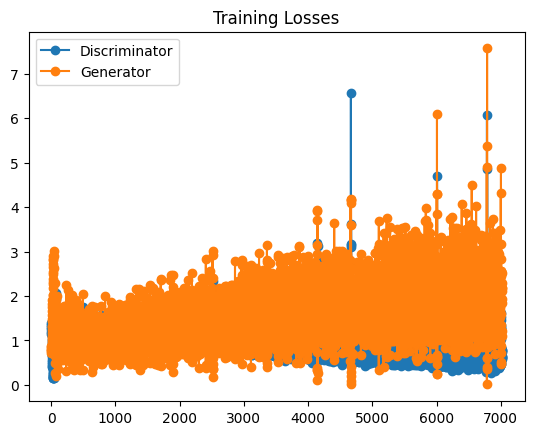

In [21]:
plt.figure()
losses = np.array(losses)
plt.plot(losses[:,0], "o-", label='Discriminator')
plt.plot(losses[:,1], "o-", label='Generator')
plt.title("Training Losses")  
plt.legend()

Now we can use the generator to generate new images.Generate new latent space samples $z$ and use the generator $G(z)$ to generate new images.

*Generate new latent space samples $z$ and use the generator $G(z)$ to generate new images.*

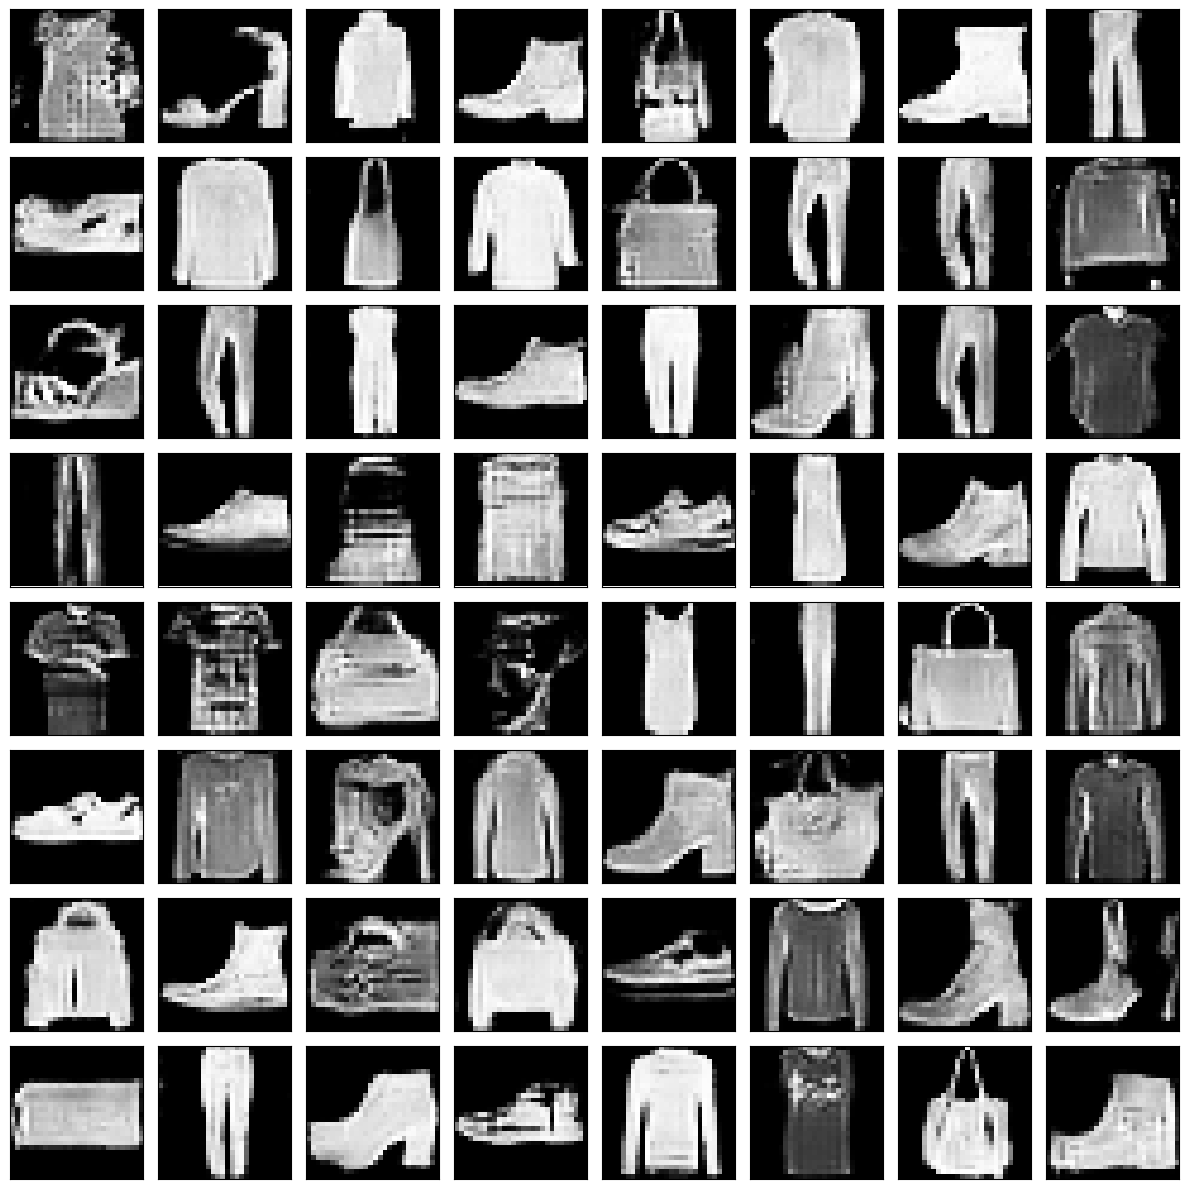

In [22]:
G.eval()

with torch.no_grad():
    # Generate images
    # TODO
    z = torch.randn(batch_size, z_size).to(device)
    images = G(z)

fig = plt.figure(figsize=(12,12))
for idx in range(64):
    ax = fig.add_subplot(8, 8, idx + 1, xticks=[], yticks=[])

    img = images[idx].detach().cpu().numpy()
    
    img = img * 0.5 + 0.5
    
    img = np.transpose(img, (1, 2, 0))
    
    ax.imshow(img, cmap='gray')
    
    # Get name
    name = str(labels[idx].item())
    
plt.tight_layout()
plt.show()

As we can see, the generated images are pretty decent, compared to the real ones.

Since we stored some samples during training, we can also visualise how the generator evolves during training. On order to show more examples at the beginning of training, we use `np.logspace` to generate the indices of the time steps we want to visualize:

In [23]:
ss = np.logspace(0, np.log10(len(samples) - 1), num=10, dtype=int)
ss

array([   1,    2,    7,   19,   51,  137,  366,  980, 2623, 7019])

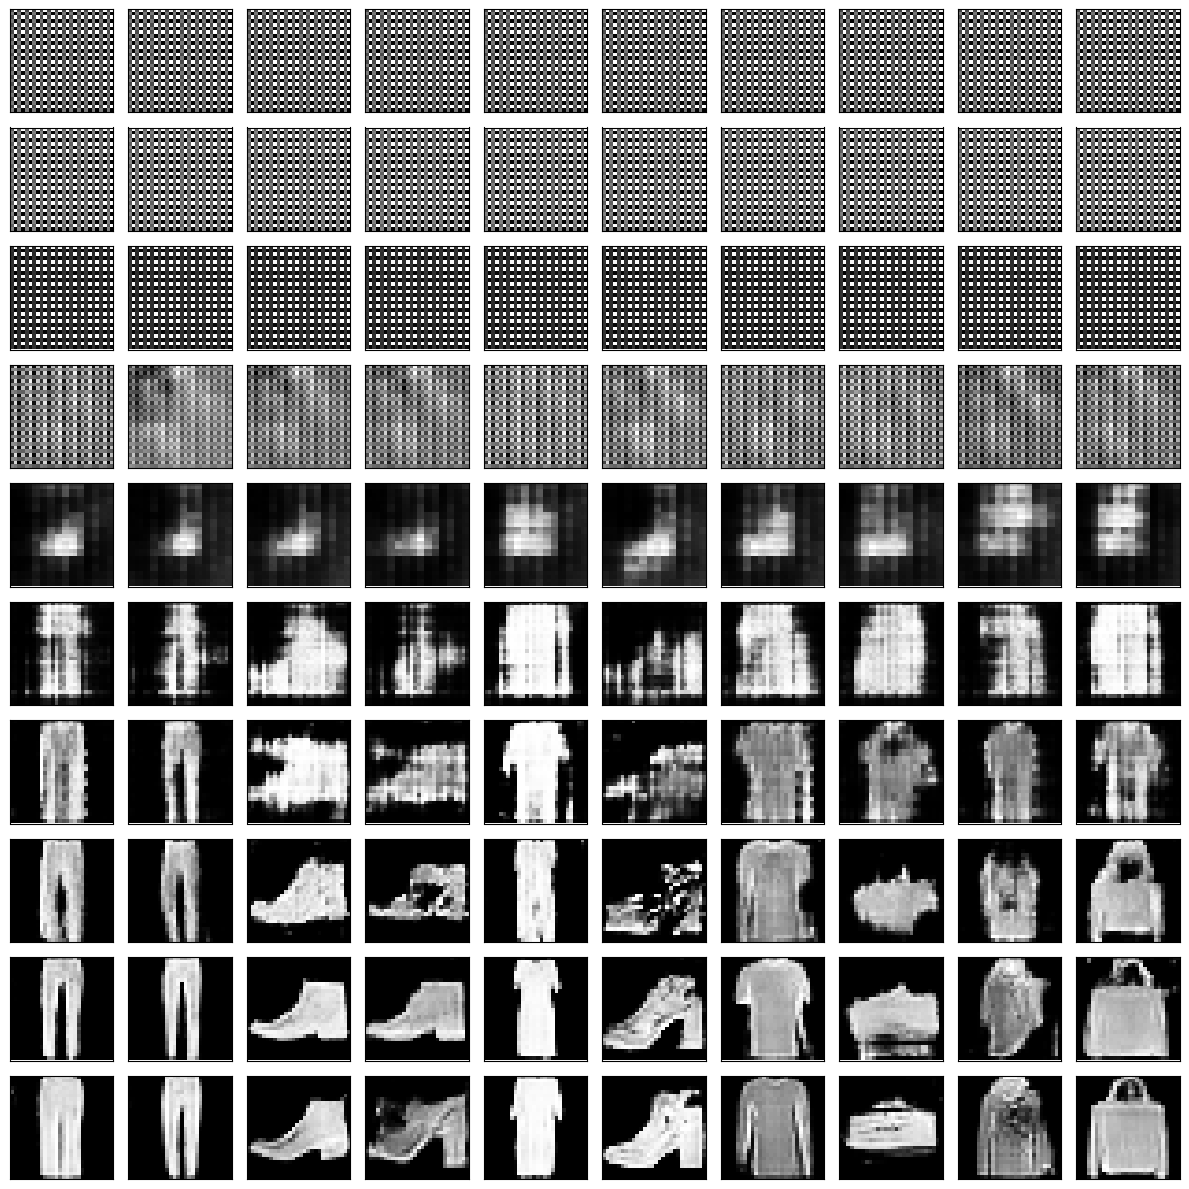

In [24]:
n = len(ss)

fig = plt.figure(figsize=(12,12))
for row, s in enumerate(ss):
    for col in range(10):
        ax = fig.add_subplot(n, 10, col + 10 * row + 1, xticks=[], yticks=[])

        img = samples[s][col].detach().cpu().numpy()
        
        img = img * 0.5 + 0.5

        img = np.transpose(img, (1, 2, 0))
        
        ax.imshow(img, cmap='gray')

        # Remove axes
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

plt.tight_layout()
plt.show()